# Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Taylor

In [16]:
def taylor(order=50):
    taylor = []
    for i in range(order):
        taylor.append(((-1) ** i) / np.math.factorial(1 + 2 * i))
    return taylor

def taylor_sine(value):
    coefs = taylor()
    result = 0
    for i in range(len(coefs)):
        result += (value ** (1 + 2 * i)) * coefs[i]
    return result

# Sine

In [17]:
class Sine:
    def __init__(self, coefs=None):
        self.coefs_amount = 25
        if coefs is None:
            self.coefs = np.array([(-1) ** c * np.random.rand() for c in range(self.coefs_amount)])
        else:
            self.coefs = coefs[:self.coefs_amount]
        self.coefs[0] = 1
        
    def __call__(self, value):
        result = 0
        for i in range(len(self.coefs)):
            result += (value ** (1 + 2 * i)) * self.coefs[i]
        return result

# Population class with methods for GA

Fitness function (one variation) - $ F = \max((taylor(i) - f(x))^2); i \in (-2\pi; 2\pi), step = 0.01 $

In [30]:
class Population:
    def __init__(self, mode='max'):
        self.population_size = 128
        self.population = [Sine() for i in range(0, self.population_size)]
        self.population_fitness = np.ones_like(self.population)
        self.generation = 0
        self.taylor = taylor()
        self.fitness_mode = mode

    def fitness(self, f):
        x = np.arange(-np.pi, np.pi, 0.01)
        s = Sine(coefs=taylor())
        y = np.multiply(f(x), list(range(-len(x) // 2, len(x) // 2)))
        y2 = np.multiply(s(x), list(range(-len(x) // 2, len(x) // 2)))
        if self.fitness_mode == 'max':
            return np.max((np.array(y2) - np.array(y)) ** 2)
        elif self.fitness_mode == 'sum':
            return np.sum((np.array(y2) - np.array(y)) ** 2) / len(y)

    def fitness_over_population(self):
        self.population_fitness = [self.fitness(sine) for sine in self.population]
        
    def best_sine(self):
        return self.population[np.argmin(self.population_fitness)]
    
    def least_error(self):
        return np.min(self.population_fitness)
    
    def selection(self):
        """Tournament selection."""
        new_population = []
        population_len = len(self.population)
        chunks = np.random.choice(population_len, size=(min(64, self.population_size // 2), 2), replace=False)
        for ind1, ind2 in chunks:
            fitness1 = self.fitness(self.population[ind1])
            fitness2 = self.fitness(self.population[ind2])
            if fitness1 < fitness2:
                new_population.append(self.population[ind1])
            else:
                new_population.append(self.population[ind2])
        self.generation += 1
        self.population = new_population

    def crossing(self):
        population_len = len(self.population)
        for i in range(population_len - 1):
            for j in range(i + 1, population_len):
                coefs = (self.population[i].coefs + self.population[j].coefs) / 2
                coefs[0] = 1
                self.population.append(Sine(coefs=coefs))

    def mutation(self):
        chunks = np.random.choice(len(self.population), self.population_size // 2)
        for i in chunks:
            for j in range(2, len(self.population[i].coefs)):
                if np.random.rand() < 0.5:
                    self.population[i].coefs[j] += self.population[i].coefs[j] * (4 - np.random.choice(8))

In [31]:
sine = Sine()
sine.coefs = taylor()[:sine.coefs_amount]

x = np.arange(-2 * np.pi, 2 * np.pi, 0.001)
y = taylor_sine(x)

# GA

<IPython.core.display.Javascript object>


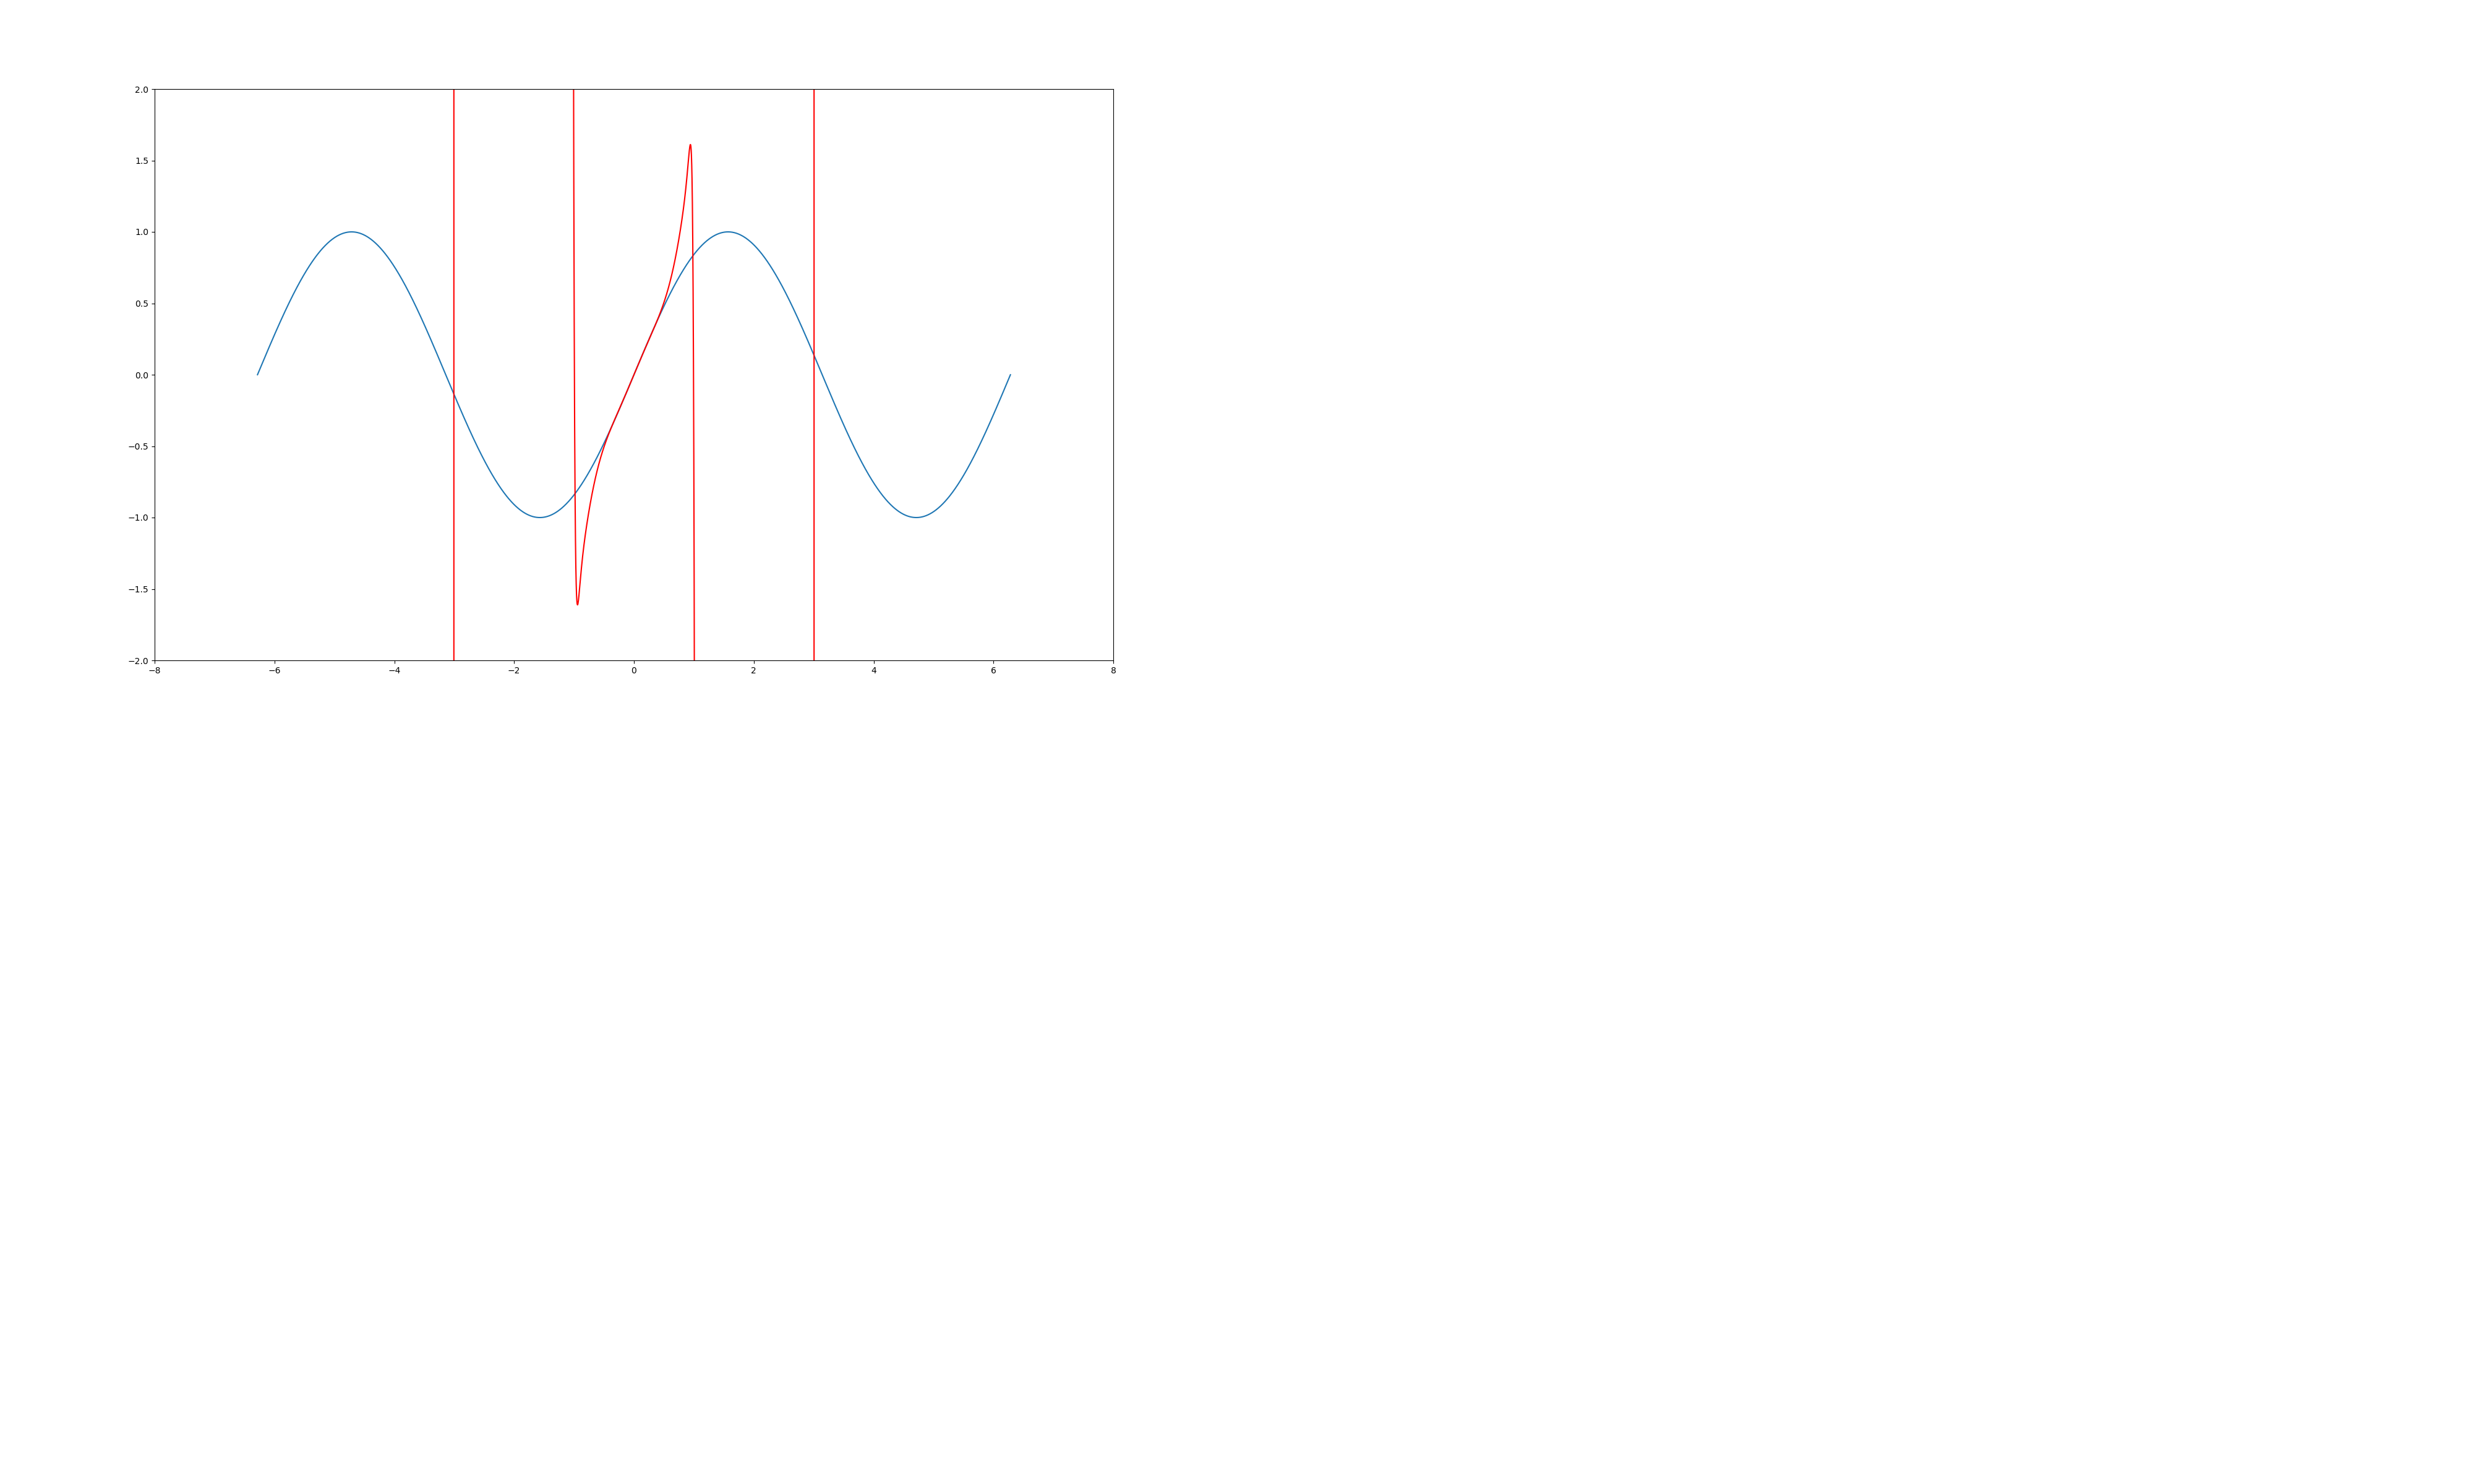

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


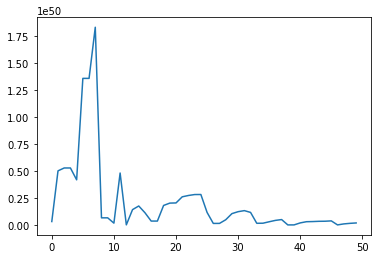

In [32]:
def ga(mode='max'):
    population = Population(mode=mode)
    history = []
    sines = {}

    %matplotlib notebook
    %matplotlib notebook

    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111)
    plt.ion()
    plt.xlim(-8, 8)
    plt.ylim(-2, 2)
    fig.show()
    fig.canvas.draw()

    for i in tqdm(range(50), position=0):
        population.generation += 1
        population.crossing()
        population.mutation()
        population.selection()
        population.fitness_over_population()
        y2 = population.best_sine()(x)
        
        ax.clear()
        ax.plot(x, y)
        ax.plot(x, y2, color='red')
        ax.set_xlim([-8, 8])
        ax.set_ylim([-2, 2])
        fig.canvas.draw()

        sines[np.min(population.population_fitness)] = population.best_sine()
        history.append(population.least_error())
        
    %matplotlib inline 
    plt.plot(list(range(len(history))), history)
    
    return sines[min(sines)]
        
sine_sum = ga(mode='sum')

(-2, 2)

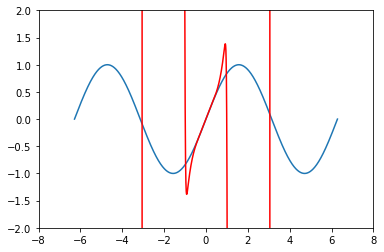

In [37]:
y_sine_sum = sine_sum(x)
plt.plot(x, y)
plt.plot(x, y_sine_sum, color='red')
plt.xlim([-8, 8])
plt.ylim([-2, 2])

<IPython.core.display.Javascript object>


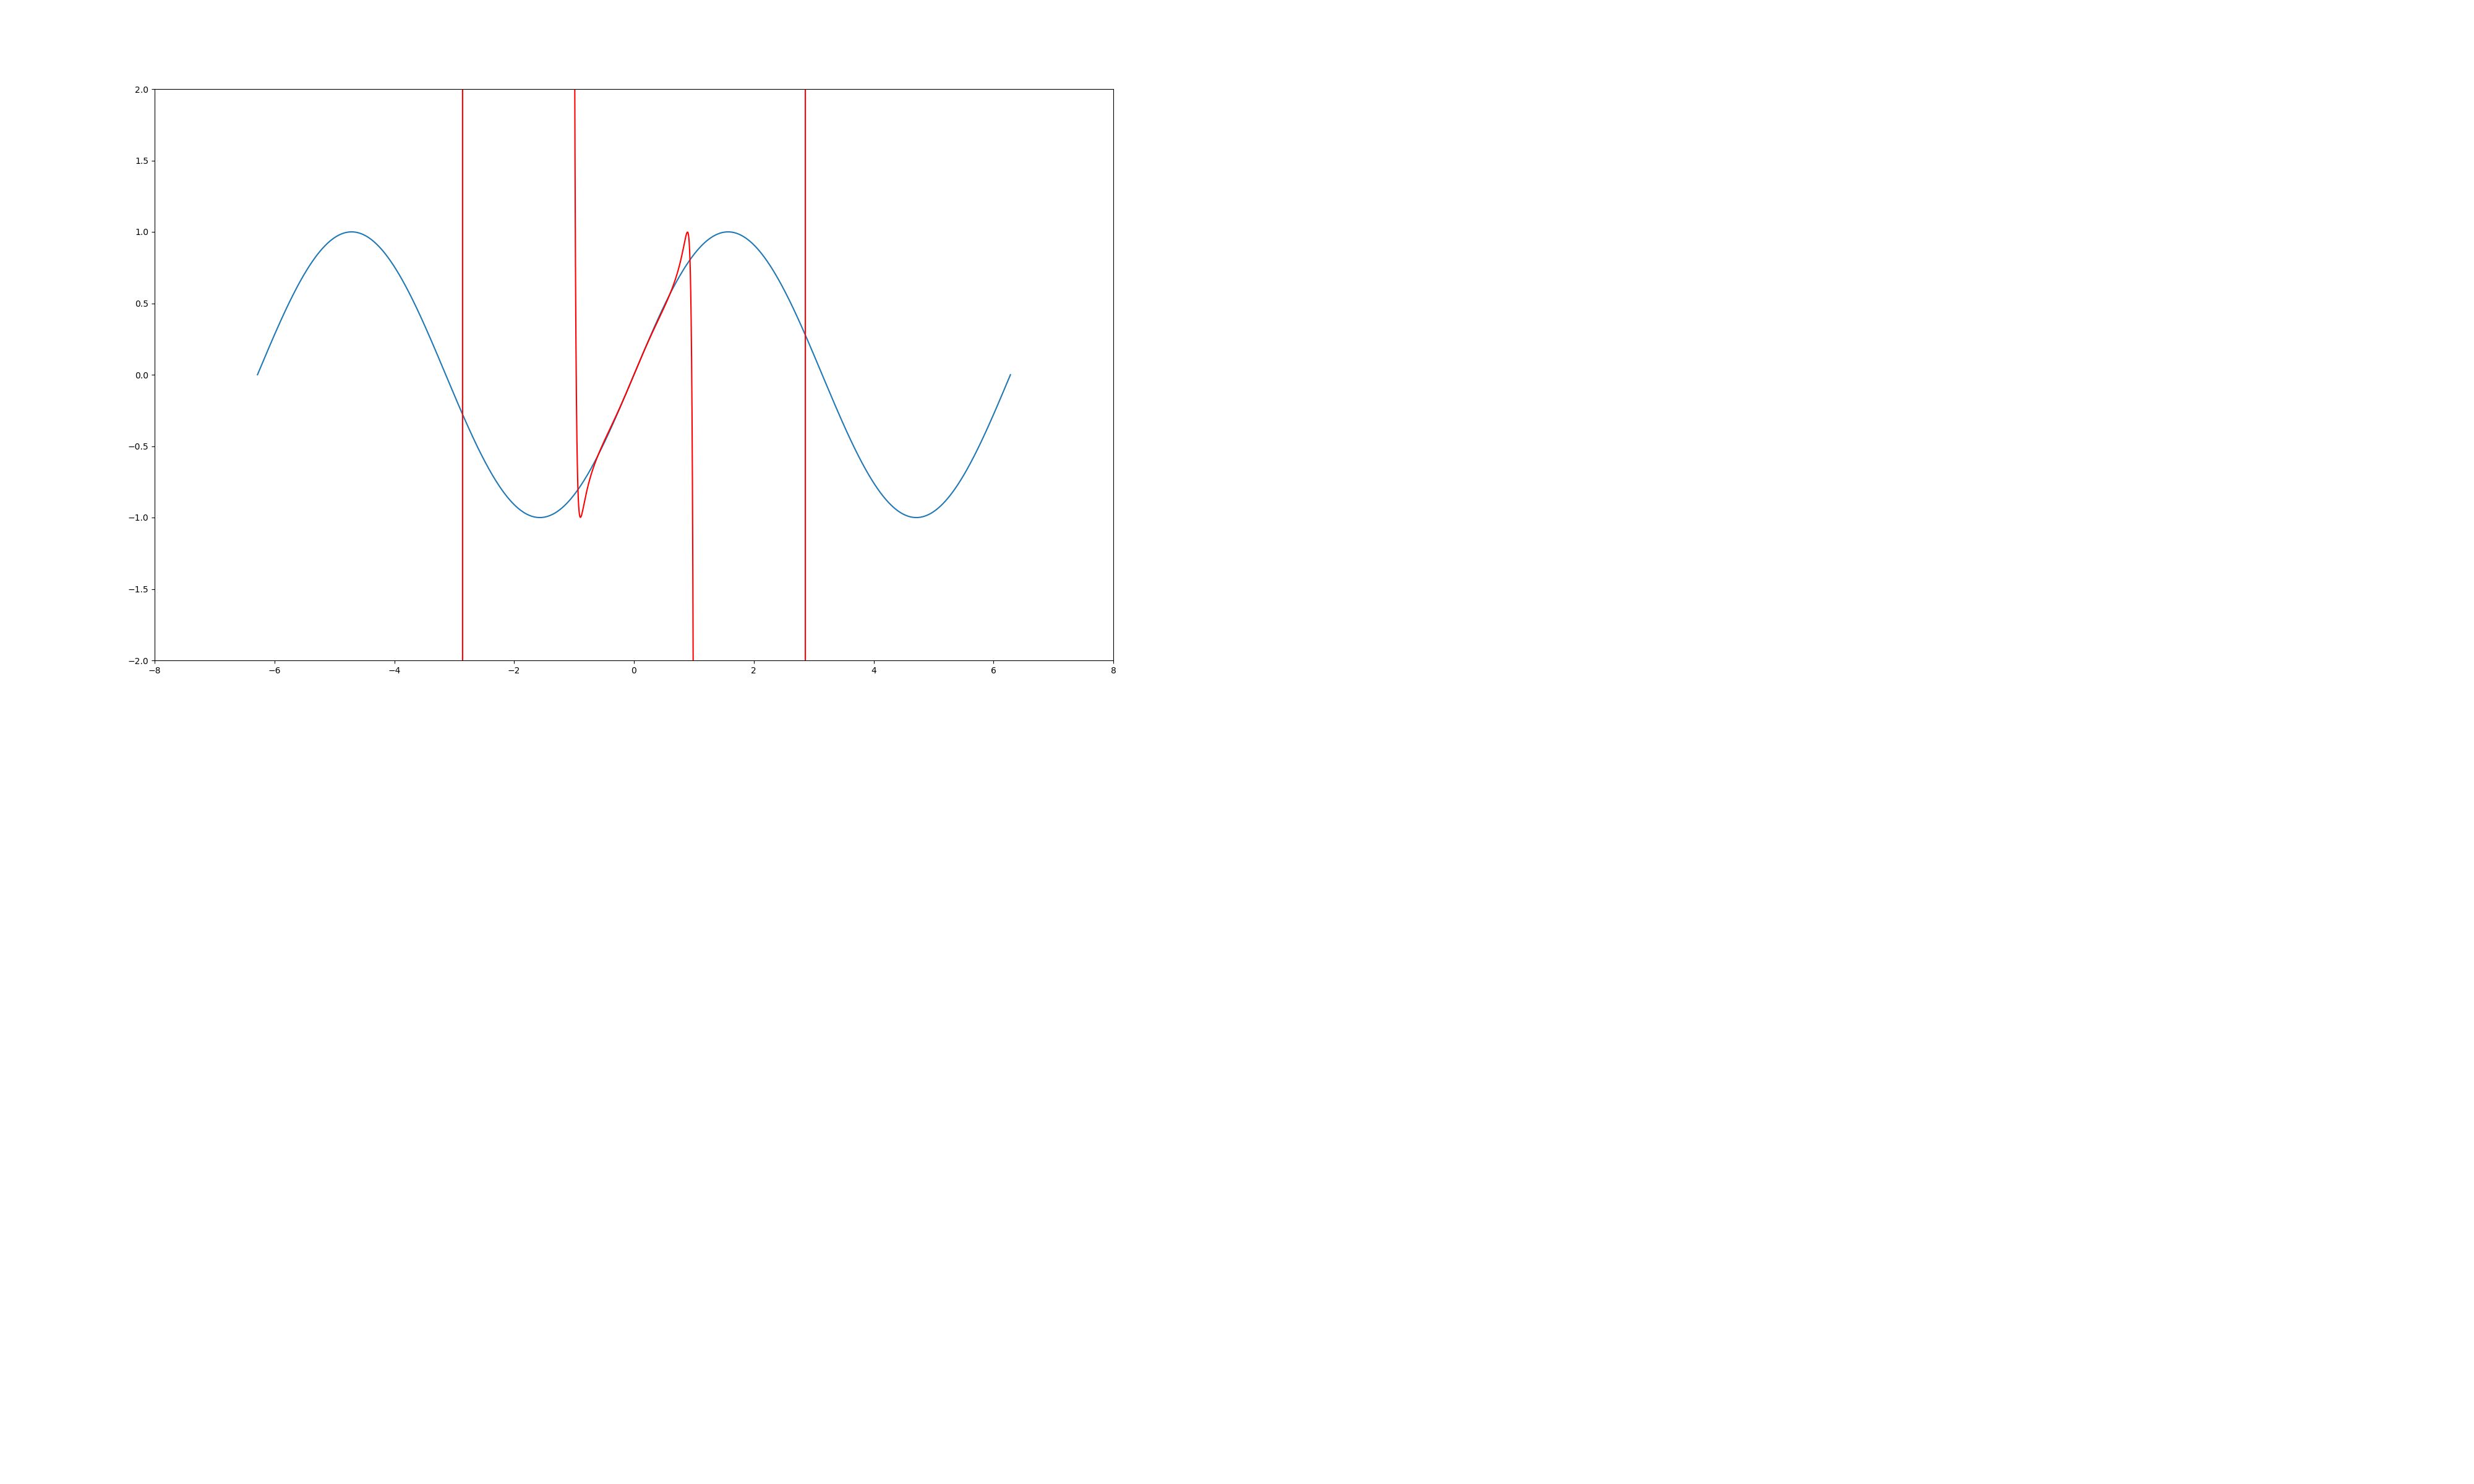

100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


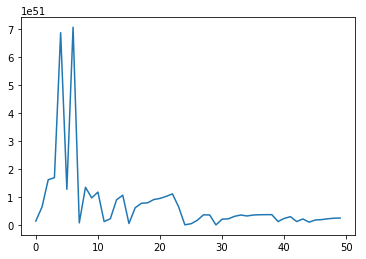

In [38]:
sine_max = ga(mode='max')

(-2, 2)

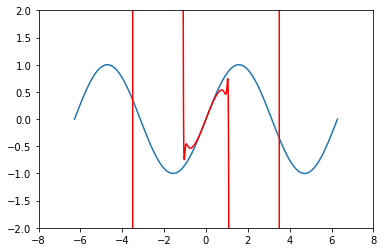

In [34]:
y_sine_max = sine_max(x)
plt.plot(x, y)
plt.plot(x, y_sine_sum, color='red')
plt.xlim([-8, 8])
plt.ylim([-2, 2])

In [41]:
sine_max(1/6 * np.pi) + sine_max(1/12 * np.pi), np.sin(1/6 * np.pi) + np.sin(1/12 * np.pi)

(0.6858250732736277, 0.7588190451025207)

In [42]:
sine_sum(1/6 * np.pi) + sine_sum(1/12 * np.pi), np.sin(1/6 * np.pi) + np.sin(1/12 * np.pi)

(0.7850461899656632, 0.7588190451025207)